In [14]:
import loconsensus.loconsensus as loconsensus
import locomotif.visualize as visualize
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathlib import Path
from dtaidistance import dtw_ndim

s_dir = Path('../pickles/subjects.pkl')
with open(s_dir, 'rb') as f:
    subjects = pickle.load(f)

In [20]:
sampling_frequency = 10
ts_names = [(1, 'walking'), (2, 'walking'), (3, 'walking'), (4, 'walking'), (5, 'walking'), (6, 'walking'), (7, 'walking'), (8, 'walking'), (1, 'cycling'), (2, 'cycling'), (4, 'cycling'), (5, 'cycling'), (6, 'cycling'), (7, 'cycling'), (8, 'cycling'), (1, 'desc_stairs'), (2, 'desc_stairs'), (3, 'desc_stairs'), (4, 'desc_stairs'), (5, 'desc_stairs'), (6, 'desc_stairs'), (7, 'desc_stairs'), (8, 'desc_stairs'), (1, 'rope_jumping'), (2, 'rope_jumping'), (5, 'rope_jumping'), (8, 'rope_jumping'), (9, 'rope_jumping')]
gt = [0, 0, 0, 0, 0, 0, 0, 0,
      1, 1, 1, 1, 1, 1, 1,
      2, 2, 2, 2, 2, 2, 2, 2,
      3, 3, 3, 3, 3
      ]

assert len(ts_names) == len(gt)

ts_list = [subjects.get(f'subject10{subject}').get(activity) for (subject, activity) in ts_names]
ts_list = [ts[:, 6:] for ts in ts_list]


In [8]:
ds = dtw_ndim.distance_matrix(ts_list, use_c=True)
ds = (ds - ds.min()) / (ds.max() - ds.min())
print(ds)

[[0.         0.63098888 0.7982571  0.76848839 0.71102729]
 [0.63098888 0.         1.         0.92202733 0.86408877]
 [0.7982571  1.         0.         0.6186805  0.73628133]
 [0.76848839 0.92202733 0.6186805  0.         0.71459608]
 [0.71102729 0.86408877 0.73628133 0.71459608 0.        ]]


In [5]:
n = len(ts_list)
global_offsets = np.cumsum([0] + [len(ts) for ts in ts_list])
l_min = 15
l_max = 30
rho = 0.8

nb = None

ms = loconsensus.apply_loconsensus(ts_list, l_min, l_max, rho, nb, overlap=0.5)

In [9]:
cm = []
for _, mset, _, bf in ms:
    cm.append((mset, bf))

cms = []
for mset, bf in cm:
    m = {i: [] for i in range(n)}
    for (s, e) in mset:
        i = np.sum(global_offsets <= s) - 1
        m[i].append(((s - global_offsets[i], e - global_offsets[i]), bf))
    cms.append(m)

S = np.zeros((n, n))

for cs in cms:
    for i in range(n):
        for j in range(n):
            cs1 = cs[i]
            cs2 = cs[j]
            mbf = 0
            for c in cs1:
                smbf = c[1]
                if smbf > mbf:
                    mbf = smbf
            for c in cs2:
                smbf = c[1]
                if smbf > mbf:
                    mbf = smbf
            if mbf == 0:
                continue
            # print(f'{mbf} // {len(cs1)} {len(cs2)}')
            S[i, j] += mbf * min(len(cs1), len(cs2))

smin = S.min()
smax = S.max()
S = (S - smin) / (smax - smin)

D = 1 - S
D[np.diag_indices(len(D))] = 0

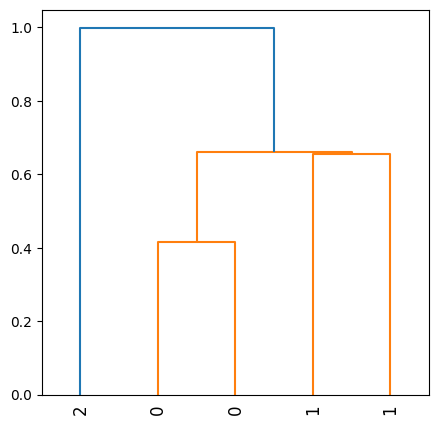

                    Method  ARI  NMI
0      Spectral Clustering  1.0  1.0
1  Hierarchical Clustering  1.0  1.0


In [10]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import pandas as pd

ts_names = gt

Cs = []
Zs = []
n_clust = 3
for n in [n_clust]:
    spectral = SpectralClustering(n_clusters=n, affinity='precomputed')
    clusters = spectral.fit_predict(S)
    Cs.append(clusters)
    Z = linkage(squareform(D), method='single')
    h = fcluster(Z, n, criterion='maxclust')
    Zs.append(h)
    fig, ax = plt.subplots(figsize=(5, 5))
    dendrogram(Z, labels=ts_names, ax=ax, leaf_rotation=90)
    plt.show()

df = pd.DataFrame({'Label': ts_names})
for i, n in enumerate([n_clust]):
    df[f'Spectral {n}'] = Cs[i]
    df[f'Hierarchical {n}'] = Zs[i]

df.set_index('Label', inplace=True)
#print(df)

ari2 = adjusted_rand_score(gt, Cs[0])
ari3 = adjusted_rand_score(gt, Zs[0])
nmi2 = normalized_mutual_info_score(gt, Cs[0])
nmi3 = normalized_mutual_info_score(gt, Zs[0])
df_metrics = pd.DataFrame({
    'Method': ['Spectral Clustering', 'Hierarchical Clustering'],
    'ARI': [ari2, ari3],
    'NMI': [nmi2, nmi3]
})
print(df_metrics)

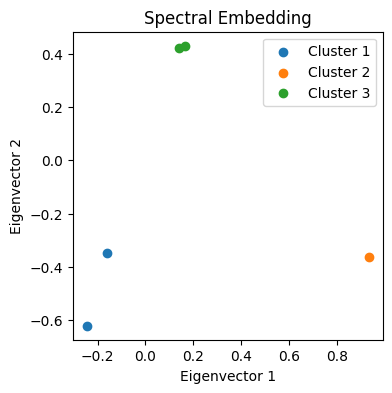

In [11]:
from scipy.linalg import eigh
from scipy.sparse.csgraph import laplacian
L = laplacian(S, normed=True)

eigenvalues, eigenvectors = eigh(L)
#embedding = eigenvectors[:, 1:3]
embedding = eigenvectors[:, 1:3]

plt.figure(figsize=(4, 4))
for i in range(n_clust):
    plt.scatter(embedding[clusters == i, 0], embedding[clusters == i, 1], label=f'Cluster {i+1}')
plt.title('Spectral Embedding')
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.legend()
plt.show()

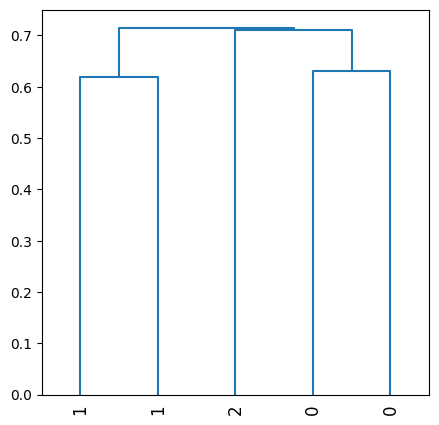

ari: 1.0 // nmi: 1.0


In [12]:
Z1 = linkage(squareform(ds), method='single')
h1 = fcluster(Z1, n, criterion='maxclust')
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z1, labels=ts_names, ax=ax, leaf_rotation=90)
plt.show()
ari4 = adjusted_rand_score(gt, h1)
nmi4 = normalized_mutual_info_score(gt, h1)
print(f'ari: {ari4} // nmi: {nmi4}')

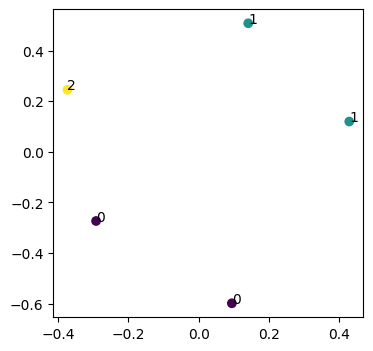

In [13]:
from sklearn.manifold import MDS

mds2 = MDS(n_components=2, dissimilarity='precomputed')
points2 = mds2.fit_transform(ds)

plt.figure(figsize=(4, 4))
scatter = plt.scatter(points2[:, 0], points2[:, 1], c=gt)
for i, label in enumerate(ts_names):
    #plt.annotate(label[1], (points2[i, 0], points2[i, 1]))
    plt.annotate(label, (points2[i, 0], points2[i, 1]))